# week4

## Motion Estimation

Many applications, like Object Tacking, Human Computer Interaction, Temporal Interpolation, Spatio-Temporal Filtering, Compression... We'll talk about Phase Correlation, Block Matching, Gradient methods, and Color. 2D agains 3D Motion: from $x, y, t$ to $x_w,y_w,z_w,t_w$. We'll deal with 2D Motion. The Optical Flow is the change of light in the image due to the relative motion between camera/eye and scene, so we can get the 2D Motion. We have then two cases: 

Non-zero true motion but Zero optical flow

Zero true motion but non-zero Optical Flow


## Phase Correlation

Methods of Motion Estimation are $\textbf{Direct}$: Phase Correlation, Block Matching, Spatio-Temporal gradient (Optical Flow and Pel-Recursive) and $\textbf{Indirect}$ Methods (like Feature Matching).

In [1]:
%matplotlib inline
# set ffmpeg reachable in the Path...
import cv2
import os
print(cv2.__version__)
basepath = 'media'
vidcap = cv2.VideoCapture(os.path.join(basepath,'MOV_0018.mp4'))
success,image = vidcap.read()
count = 0
success = True
# this will take up to 30"
while success:
    success, image = vidcap.read()
    # get frames out of a movie
    cv2.imwrite(os.path.join(basepath,"frame%d.jpg" % count), image) # save frame as JPEG
    count += 1


2.4.2


We have seen that with phase shift the Transform will also change, by multiplying it by complex exponentials:

$$
x(n_1,n_1) \rightarrow X(\omega_1, \omega_2)
$$

$$
x(n_1-m_1,n_2-m_2) \rightarrow e^{-j\omega_1 m_1} e^{-j\omega_3 m_2} X(\omega_1, \omega_2)
$$

But that implies using the continuous Fourier Transform, and that's not computable. Instead, we produce the DFT, Discrete Fourier Transform, using FFT implementation. The images are not related by circular shift, but a linear shift... therefore we need a Window. Analytically:

$$
X_t(k_1, k_2) = X_{t-1}(k_1,k_2) e^{-j \frac{2 \pi}{N_1} m_1 k_1} e^{-j \frac{2 \pi}{N_2} m_2 k_2}
$$

The correlation image $C$ will be:

$$
C(k_1,k_2)=\frac{X_t(k_1,k_2) \cdot X^{*}_{t-1}(k_1,k_2)}{|X_t(k_1,k_2) X^{*}_{t-1}(k_1,k_2)|}
$$

Which, if I substitute, it gives:

$$
C(k_1,k_2)=e^{-j \frac{2 \pi}{N_1} m_1 k_1} e^{-j \frac{2 \pi}{N_2} m_2 k_2}
$$

which, in the Spatial Domain, it is a Dirac delta:

$$
c(n_1,n_2) = \delta(n_1-m_1,n_2-m_2)
$$

((0, 1920), (0, 1080))

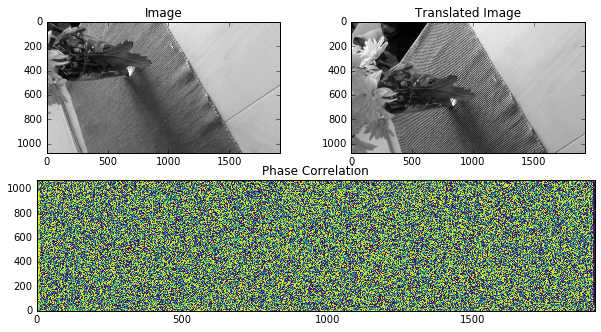

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
from scipy import signal, misc, ndimage
import numpy as np

I1 = misc.imread(os.path.join('media','frame119.jpg') );
I2 = misc.imread(os.path.join('media','frame139.jpg') );
I1g = misc.imread(os.path.join('media','frame119.jpg'), mode='L')
I2g = misc.imread(os.path.join('media','frame139.jpg'), mode='L')

LPF2 = np.array([[1./25, 1./25, 1./25, 1./25, 1./25],
                 [1./25, 1./25, 1./25, 1./25, 1./25],
                 [1./25, 1./25, 1./25, 1./25, 1./25],
                 [1./25, 1./25, 1./25, 1./25, 1./25],
                 [1./25, 1./25, 1./25, 1./25, 1./25]])
Jx_d1 = ndimage.convolve(I1g, LPF2, mode='nearest')
Jx_d2 = ndimage.convolve(I2g, LPF2, mode='nearest')
N1 = Jx_d1.shape[0]; N2 = Jx_d1.shape[1];

x = np.array(range(np.size(I1g,0))); y = np.array(range(np.size(I1g,1)))
X,Y = np.meshgrid(y,x)
HX1 = np.fft.fft2(I1g)
HX2 = np.fft.fft2(I2g)
C = (HX1 * np.conjugate(HX2)) / np.abs(HX1 * np.conjugate(HX2))
HX1l = np.fft.fft2(Jx_d1)
HX2l = np.fft.fft2(Jx_d2)
Cl = (HX1l * np.conjugate(HX2l)) / np.abs(HX1l * np.conjugate(HX2l))


fig=plt.figure(figsize=(10, 8))
ax1=plt.subplot(3, 2, 1)
plt.imshow(I1g,cmap='gray')
plt.title('Image')
ax2=plt.subplot(3, 2, 2)
plt.imshow(I2g,cmap='gray')
plt.title('Translated Image')

ax3 = plt.subplot(3, 1, 2)
ax3.pcolormesh(X,Y,C.real,cmap='viridis')
plt.title('Phase Correlation')
plt.xlim(0, I1g.shape[1]), plt.ylim(0, I1g.shape[0])

# ax4 = plt.subplot(3, 1, 3)
# ax4.pcolormesh(X,Y,Cl.real,cmap='viridis')
# plt.title('Phase Correlation')
# plt.xlim(0, I1g.shape[1]), plt.ylim(0, I1g.shape[0])

#...mmm


## Block Matching

Motion Estimation is still one of the computationally hard matters. Block Matching is the most used. Once the match is found, I can get the relative movement of the block. I'm looking to a local block only (No global movement). I could even associate the movement to one-pixel only (like the center), however there's no one-to-one relation possible. The assumptions are:

There's no change in the ambient light (Optical Flow corresponds to Motion)

Objects are rigid (Rigid transformation)

Objects are translated in a 2D plane, parallel to the image plane

No objects appeared or left the scene

We should define the matching criteria, though. We can use blocks, or any arbitrarly shaped regions. 

$$
\epsilon(d_1,d_2) = \sum\limits_{(m_1,m_2) \in N } \Phi(x_t(n_1+m_1,n_2+m_2),x_{t-1}(n_1+m_1+d_1,n_2+m_2+d_2))
$$

with $d$ being the displacement. By $\Phi()$, we can use a Correlation Function, the MeanSquared Error (MSE) or the Mean Absolute Error (MAE) or the Mean Absolute Difference (MAD). In the latter case, for example, it will be:

$$
\epsilon(d_1,d_2) = \sum\limits_{(m_1,m_2) \in N } |(x_t(n_1+m_1,n_2+m_2)-x_{t-1}(n_1+m_1+d_1,n_2+m_2+d_2)|
$$

The accuracy of the estimation should be as high as possible, however if the motion is used for compression, then we can trade off by using a computationally quicker method. The center of the blovk will be $(n_1,n_2)$. If the frame has $M$x$N$ pixels, then we have $M$x$N$ matching comparison. The distance will be computed as pixels, and velocity will pixels/frame_rate  Also, it is good to define a Search Region $K$x$L$. Even after we restrict the search, we would like to reduce the computational weight, with a 2D Logarithmic Search, which is basically considering the pixel that has least error and creating a number of pixels all around it, and so on.. With logarithmic Search, we have $K=log_2P$, with $P$ being such as an image would be in pixels $(2P+1)$x$(2P+1)$, and $d_1=2^{k-1}$, $d_2=2^{k-2}$, and so on... If the error function is convex in the "displacement" axis, we can find the minimum. In practice we don't know how the error looks like and the error function is usually non-convex. Another way to reduce the computation, is to use Pixel Sub-Sampling. Another method is Pixel Projection, for which the sum of the rows and the sum of the columns are used. What we use as Search Method is a part of the so-called Hierarchical Motion Estimation:

Frame -> Low pass Filter -> Down-sampled by a factor of 2 -> Frame -> Low pass Filter -> Down-sampled by a factor of 2 -> ...

To the low resolution sample, we could use global search and perform global estimation, for example: 

The estimated vector of motion estimation is multiplied by 2 -> motion estimation is performed again -> The estimated vector of motion estimation is multiplied by 2 -> motion estimation is performed again -> ...

The approach is used many times, with Integer-pel and Half-pel found by using interpolation.


Use vcDemo from http://insy.ewi.tudelft.nl/content/image-and-video-compression-learning-tool-vcdemo

## Spatio-Temporal Gradient Methods

We need both strong Spatial and Temporal edges. To do that, we will define the $\textbf{Optical Flow}$ law. Non-recursive and Recursive approach will be seen. We look at the equations. The assumption is the Constant Brightness Constraint, therefore here brightness remains the same after a translation:

$$
I(x,y,0)=I(x+u,y+y,\tau)
$$

Giving that:

$$
I_x u + I_y v + I_t \tau =0 \rightarrow I_x V_x + I_y V_y + I_t =0
$$

With $V$ being the velocity. We solve the equation by using a neighborhood of the pixel, therefore having many variables and just 2 unknowns ($V_x$,$V_y$). In matrix form, that becomes:

$$
I_{x,y}v=I_t
$$

We want to find the velocity $V$, and if $I$ is invertible:

$$
v=(I^TI)^{-1}I^TI_t
$$

Or going for a Regularized solution, which gives a smoothness constraint:

$$
v=(I^TI+\lambda C^TC)^{-1}I^TI_t
$$



Pel-Recursive Algorithms use Optical Flow equations, still with Constant brightness constraint (ambient light did not change). Say:

$$
I(\textbf{r},t)=I(\textbf{r}-\textbf{d},t-1)=I(\bar{\textbf{r}},t-1)
$$

After giving an initial estimate $\textbf{d}^1$, we set $\textbf{u}=\textbf{d}-\textbf{d}^1$ and, after Taylor approximation, we get:

$$
\Delta(\textbf{r},\textbf{u})=-\nabla^T I(\textbf{r}-\textbf{d}^1,t-1) \textbf{u}-\epsilon(\textbf{r}, \textbf{u})
$$

I'll choose pixels around, assuming I use a raster scan for that central pixel, having already an estimate for pixels around. So there are two main differences with respect to the other Optical Flow method:

The neighborhood pixels allow the recursive computability of the motion vector

Have a good estimate of the $d^i$ that will update $u=d-d^i$

This last method is used a lot in video compression, working with encoder and decoder.

There are also Feature-Based Methods, like Harris corners, SIFT, SURF,...

## Color Image Processing

Fundamentals. Color is a powerful descriptor, used for segmentation, tracking, ... Also, humans can distinguish thousands of color shades and intensities.

Color Regions: ~Ultraviolet, Violet, Blue, Green, Yellow, Orange, Red, ~Infrared. Light can be Acromatic (attribute is Intensity, only) and Chromatic (attributes are Radiance (Watts) and Luminance ( = Perceived: Lumens)), Bightness, hard to measure. There are 6-7M cones. 65% of cones are sensitive to Red. 33% Green, 2% Blue. However, the blue absorpting cones are the most sensitive. CIE (the Commission) designated the three primary colors: 435nm, 546.1nm, 700. They changed into 445nm, 535nm, 575nm (BGR). The three colors can be edit to color the three secondary colors: Cyan, Yellow, Magenta. Additive model: Green+Magenta gives White. Primary Colors of Pigments work with subtraction: C=1-R. The primary are Cyan, Magenta, Yellow. Secondary ones are Blue, Green, Red. The combination gives Black.

Color Distinguishing Characteristics: Brightness, Hue (indicates the dominant wave light), Saturation (relative purity of color or amount of white light mixed with its hue). Trichromatic Coefficients: X, Y, Z: tristimulus values. x,y,z are the trichromatic coefficients:

$$
x=\frac{X}{X+Y+Z}
$$
$$
x+y+z=1
$$

We could also use the CIE Chromaticity Diagram, with $x,y,z$. Min and Max wave lenght are 380nm and 780nm. The center of the Diagram. A Color Model specify a coordinate system where each color is represented by a single point. Most common models:

RGB

CMY and CMYK

HSI

YUV

RGB is based on the Cartesian model. 
CMY = [1 1 1]-RGB. Since together they form a muddy-black, black itself has been added forming CMYK. 
HSI: Hue has angle 0 with Red. The saturation of all Primary and Secondary colors is 1. Intensity is 1/3 of the sum of the colors. 
YUV/YCbCr the luminance component Y is separated from the Chrominance component. It used by PAL, NTSC, ... YIQ is derived from it. In YCbCr is a scaled and offset version of YUV. All of these have a formula, linear relation function of RGB. These formulas are used for JPEG compression. 


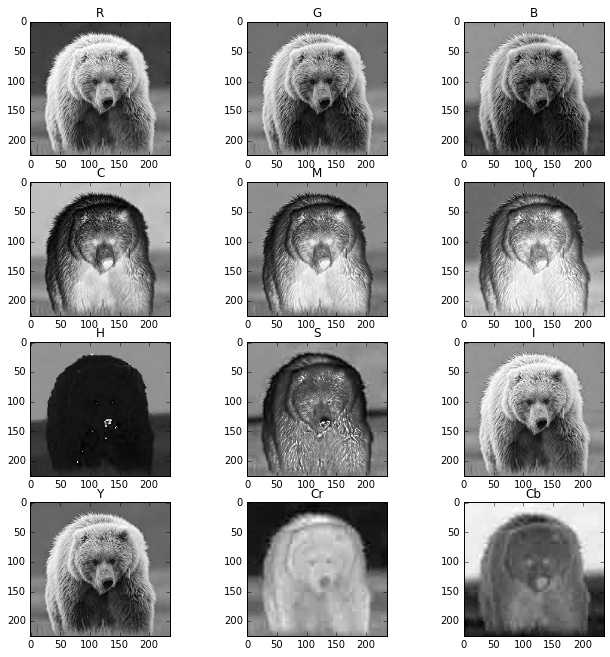

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
from scipy import signal, misc, ndimage
import numpy as np
import cv2

Irgb = misc.imread(os.path.join('media','bear.png') );
R = Irgb[:,:,0]
G = Irgb[:,:,1]
B = Irgb[:,:,2]

C = 255-R
M = 255-G
Y = 255-B

HSI = cv2.cvtColor(Irgb, cv2.COLOR_RGB2HSV)
H = HSI[:,:,0]
S = HSI[:,:,1]
I = HSI[:,:,2]

YCrCb = cv2.cvtColor(Irgb, cv2.COLOR_RGB2YCR_CB)
Yy  = YCrCb[:,:,0]
Cr = YCrCb[:,:,1]
Cb = YCrCb[:,:,2]

fig=plt.figure(figsize=(11, 11))
ax1=plt.subplot(4, 3, 1)
plt.imshow(R,cmap='gray')
plt.title('R')
ax2=plt.subplot(4, 3, 2)
plt.imshow(G,cmap='gray')
plt.title('G')
ax3=plt.subplot(4, 3, 3)
plt.imshow(B,cmap='gray')
plt.title('B')
# these are the negative of those
ax4=plt.subplot(4, 3, 4)
plt.imshow(C,cmap='gray')
plt.title('C')
ax5=plt.subplot(4, 3, 5)
plt.imshow(M,cmap='gray')
plt.title('M')
ax6=plt.subplot(4, 3, 6)
plt.imshow(Y,cmap='gray')
plt.title('Y')
ax7=plt.subplot(4, 3, 7)
plt.imshow(H,cmap='gray')
plt.title('H')
ax8=plt.subplot(4, 3, 8)
plt.imshow(S,cmap='gray')
plt.title('S')
ax9=plt.subplot(4, 3, 9)
plt.imshow(I,cmap='gray')
plt.title('I')
ax10=plt.subplot(4, 3, 10)
plt.imshow(Yy,cmap='gray')
plt.title('Y')
ax11=plt.subplot(4, 3, 11)
plt.imshow(Cr,cmap='gray')
plt.title('Cr')
ax12=plt.subplot(4, 3, 12)
plt.imshow(Cb,cmap='gray')
plt.title('Cb')



Therefore, we need to choose an appropriate color space, or with Independent channel processing, or with Multi-channel processing.